<br>
<center>
<h1>Workforce Analytics</h1>
<h2><i> - Seongmin Lee(CID: 01247436)  -</i></h2>

# Author Information on Web of Science (The Number of the authors: 1,813)

example link : http://apps.webofknowledge.com/CitationReport.do?product=WOS&search_mode=CitationReport&SID=D2SJg32DfEVuScBbuYk&page=1&cr_pqid=13&viewType=summary&colName=WOS

Based on the file named on WOS_scraped_df_ver3.pkl, I could reach the each document's information on the Web of Science directly. If the author's id coloured blue is clicked, then we could reach the author information as depicted below. The dataset could be used to measure the performance of any authors combination.

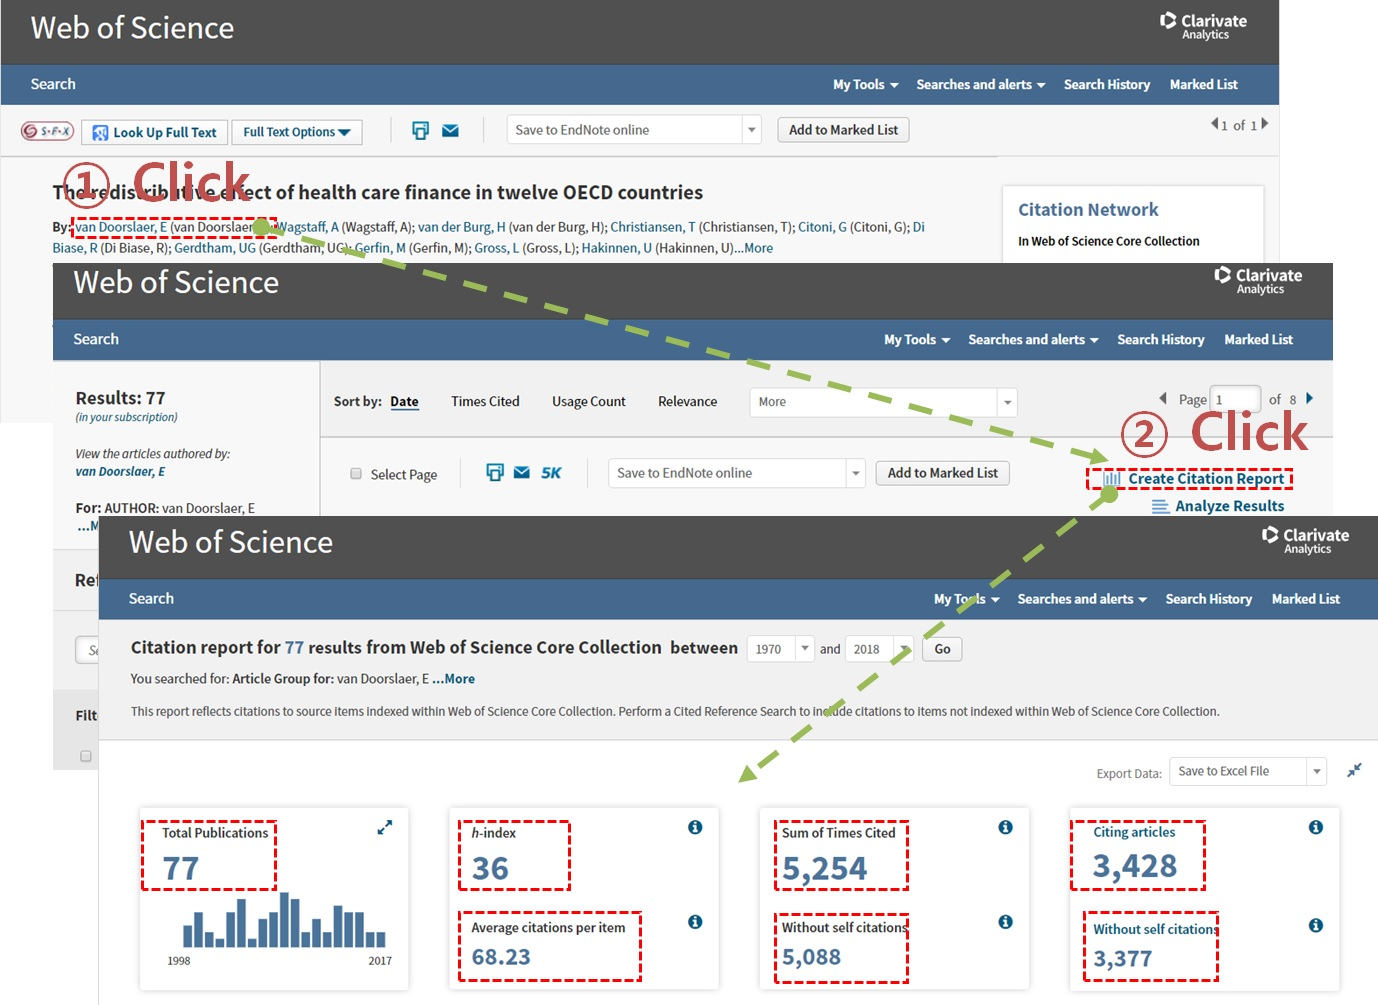

In [3]:
from IPython.display import Image
import os
Image(filename = os.getcwd()+'/img/author.jpg')

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import requests
import re
import sys
import time
import csv
from ast import literal_eval
import random

# Initial Crawling

In [9]:
def coauthors_info():
    WOS_df = pd.read_pickle('./data/WOS_scraped_df_ver3.pkl')
    WOS_df_set_URL = list(set(WOS_df.WOS_URL))
    
    #Start index designation
    try:
        author_info = pd.read_csv('./data/author_info.csv')
        end_working_url = list(author_info.publication_url)[-1]
        startidx = WOS_df_set_URL.index(end_working_url)+1 
    except:
        author_info = pd.DataFrame(columns=['publication_url','name', 'name_id', 'authors_url', 'ttl_publication', 'h-index', 'avg_citation_per_item', 'sum_of_times_cited', 'without_self_citations', 'citing_articles', 'without_self_citations_article'])
        startidx = 0
       
    for log_count, url in enumerate(WOS_df_set_URL[startidx:]):
        #Ramdonly select the ID 
        ids = ['']
        selected_id = random.choice(ids)
        passwords = ['']
        selected_pass = passwords[ids.index(selected_id)] #

        #log-in page
        chrome_options = Options()
        chrome_options.add_argument('--lang=en-us')
        driver = webdriver.Chrome(chrome_options=chrome_options,executable_path=r"C:/Users/seong/Downloads/chrome/chromedriver")
        driver.get('https://login.webofknowledge.com/error/Error?PathInfo=%2F&Error=IPError')
        driver.implicitly_wait(5)
        driver.find_element_by_name('username').send_keys(selected_id) #email id
        driver.find_element_by_name('password').send_keys(selected_pass) #password
        driver.implicitly_wait(5)
        driver.find_element_by_xpath('//*[@id="WoKerror"]/div/table[2]/tbody/tr/td[2]/form[1]/table/tbody/tr[3]/td[2]/a/button').click() #click
        try:
            driver.find_element_by_xpath('//*[@id="WoKerror"]/div/table[2]/tbody/tr/td[2]/p/a[1]').click() #exception log-in
        except:
            pass
        
        # Reaching the publication page on Web of Science
        driver.get(url)
        driver.implicitly_wait(5)
        
        # Click the bar to see the extra authors
        try:
            driver.find_element_by_xpath('//*[@id="show_more_authors_authors_txt_label"]/a').click()
            driver.implicitly_wait(5)
        except:
            pass
        
        author_info = author_info.astype('object')
        driver.implicitly_wait(5)
        soup = BeautifulSoup(driver.page_source, "html.parser")
        
        #Extract the urls for the author information
        url_parsing = soup.find_all(title=["Find more records by this author"])
        author_parsing = soup.select("a")
        # Parsing author urls
        authors_urls = ['http://apps.webofknowledge.com'+str(u.attrs['href'])for u in url_parsing if bool(re.search(r'[OneClickSearch.do?product=WOS&search_mode]', str(u.attrs['href'])))]                                                                          
        # Parsing the authors names labeld as IDs
        authors_id = [u.string.lower() for u in url_parsing if bool(re.search(r'[OneClickSearch.do?product=WOS&search_mode]', str(u.attrs['href'])))]
        # Parsing the authors names in the parenthesis 
        authors_uniq = []
        for i in author_parsing:
            try:
                if bool(re.search(r'^ \(' ,i.next_sibling)):
                    authors_uniq.append(re.sub('[^A-Za-z0-9, ]+', "", i.next_sibling).strip())
            except:
                pass        

        if len(authors_urls) == 0:
            continue
        
        #Looping the authors' url
        for idx, u in enumerate(authors_urls):
            # Excluding the crawling if the author's id is in the saving dataframe
            if authors_id[idx] in list(author_info.name_id):
                continue
            else:
                #reaching the publication list 
                driver.get(u)
                driver.implicitly_wait(15)
                try:
                    #Click the author summary page button
                    driver.find_element_by_xpath('//*[@id="view_citation_report_image_placeholder"]/div/nobr/a').click()
                    driver.implicitly_wait(15)
                except:
                    continue
                
                citation_report = BeautifulSoup(driver.page_source, "html.parser")
                values = citation_report.find_all('em',{'class':re.compile('[commafy]')})[1:]
                
                #looping the values and saving it as a dataframe
                row_num = author_info.shape[0]
                author_info.loc[row_num,'publication_url'] = url
                author_info.loc[row_num,'name'] = authors_uniq[idx]
                author_info.loc[row_num,'name_id'] = authors_id[idx]
                author_info.loc[row_num,'authors_url'] = str(u)
                print(author_info.loc[row_num,'authors_url'])
                for v, c in zip(values, author_info.columns[4:]):
                    author_info.loc[row_num, c] = v.string.strip().replace(',','')
                print("%sth. %s has been added" %(author_info.shape[0], authors_uniq[idx]))
        author_info.to_csv('./data/author_info.csv', index = None)
        driver.close()
    driver.quit()

In [10]:
coauthors_info() # 중복이슈

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F1QdVqP4kbj5gVLFxNg&author_name=Luft, HS&dais_id=112214&excludeEventConfig=ExcludeIfFromFullRecPage
1083th. Luft, Harold S has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F1QdVqP4kbj5gVLFxNg&author_name=Guadagnoli, E&dais_id=241787&excludeEventConfig=ExcludeIfFromFullRecPage
1084th. Guadagnoli, Edward has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=D2ZmxCc1vc3cgDLbfd2&author_name=Bernard, AB&dais_id=902389&excludeEventConfig=ExcludeIfFromFullRecPage
1085th. Bernard, Andrew B has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=D2ZmxCc1vc3cgDLbfd2&author_name=Massari, R&dais_id=24495206&excludeEventConfig=ExcludeIfFromFullRecPage
1086th. Mas

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E12wh76HKnf6bnizBX1&author_name=Barr, D&dais_id=8416565&excludeEventConfig=ExcludeIfFromFullRecPage
1116th. Barr, D has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E12wh76HKnf6bnizBX1&author_name=Breedon, F&dais_id=7094056&excludeEventConfig=ExcludeIfFromFullRecPage
1117th. Breedon, F has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F4colAW5vJg9m2MWHsZ&author_name=Shearer, A&dais_id=2000486&excludeEventConfig=ExcludeIfFromFullRecPage
1118th. Shearer, A has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E5HR99qR4pSF14f9YHp&author_name=De Waele, K&dais_id=30194121&excludeEventConfig=ExcludeIfFromFullRecPage
1119th. De Waele, K has been added

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E5exiWZQCxnaZWdVrfj&author_name=Jackwerth, J&dais_id=14559386&excludeEventConfig=ExcludeIfFromFullRecPage
1149th. Jackwerth, J has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F4lLAfOJ3Nrv5EjVAqk&author_name=Heide, J&dais_id=21567700&excludeEventConfig=ExcludeIfFromFullRecPage
1150th. Heide, Jan has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C3BpSMt1sjtDFYoNpgW&author_name=Vedolin, A&dais_id=6005562&excludeEventConfig=ExcludeIfFromFullRecPage
1151th. Vedolin, Andrea has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C2ojD7wqZoWc9JOKdwj&author_name=LOCKLEY, H&dais_id=26349181&excludeEventConfig=ExcludeIfFromFullRecPage
1152th. LOCKLEY, H h

#  Re-scraping the missing authors

In [3]:
author = pd.read_csv('./data/author_info_recheck.csv')
WOS_df = pd.read_pickle('./data/WOS_scraped_df_ver3.pkl')

## Find the missing authors

In [44]:
# adding the index of those authors that could not be scraped due to the network issue
researching_index = []
for idx, names in enumerate(WOS_df.co_author1):
    for name in names:
        if not name.lower() in list(author.name_id):
            researching_index.append(idx)

WOS_df.loc[researching_index, :].to_pickle('./data/WOS_df_author.pkl')

## Re-scrape

In [47]:
#Same code as above
def coauthors_info_recheck():

    WOS_df = pd.read_pickle('./data/WOS_df_author.pkl')
    WOS_df_set_URL = list(set(WOS_df.WOS_URL))
    
    author_info = pd.read_csv('./data/author_info_recheck.csv')
            
    for url in WOS_df_set_URL:
        ids = ['id']
        selected_id = random.choice(ids)
        passwords = ['pss']
        selected_pass = passwords[ids.index(selected_id)]

        #log-in page
        #Activate the Chrome Browser
        chrome_options = Options()
        chrome_options.add_argument('--lang=en-us')
        driver = webdriver.Chrome(chrome_options=chrome_options,executable_path=r"C:/Users/seong/Downloads/chrome/chromedriver")
        driver.get('https://login.webofknowledge.com/error/Error?PathInfo=%2F&Error=IPError')
        driver.implicitly_wait(5)
        driver.find_element_by_name('username').send_keys(selected_id) #email id
        driver.find_element_by_name('password').send_keys(selected_pass) #password
        driver.implicitly_wait(5)
        driver.find_element_by_xpath('//*[@id="WoKerror"]/div/table[2]/tbody/tr/td[2]/form[1]/table/tbody/tr[3]/td[2]/a/button').click() #click
        try:
            driver.find_element_by_xpath('//*[@id="WoKerror"]/div/table[2]/tbody/tr/td[2]/p/a[1]').click() #exception log-in
        except:
            pass
        driver.get(url)
        driver.implicitly_wait(5)
        
        # Click the bar to see the extra authors
        try:
            driver.find_element_by_xpath('//*[@id="show_more_authors_authors_txt_label"]/a').click()
            driver.implicitly_wait(5)
        except:
            pass
        
        author_info = author_info.astype('object')
        driver.implicitly_wait(5)
        soup = BeautifulSoup(driver.page_source, "html.parser")
        url_parsing = soup.find_all(title=["Find more records by this author"])
        author_parsing = soup.select("a")
        
        #url list
        authors_urls = ['http://apps.webofknowledge.com'+str(u.attrs['href'])for u in url_parsing if bool(re.search(r'[OneClickSearch.do?product=WOS&search_mode]', str(u.attrs['href'])))]
        #author name list                                                                             
        authors_id = [u.string.lower() for u in url_parsing if bool(re.search(r'[OneClickSearch.do?product=WOS&search_mode]', str(u.attrs['href'])))]
        
        authors_uniq = []
        for i in author_parsing:
            try:
                if bool(re.search(r'^ \(' ,i.next_sibling)):
                    authors_uniq.append(re.sub('[^A-Za-z0-9, ]+', "", i.next_sibling).strip())
            except:
                pass        

        if len(authors_urls) == 0:
            continue
        
        for idx, u in enumerate(authors_urls):
            if authors_id[idx] in list(author_info.name_id):
                continue 
            else:
                #reaching the publication list 
                driver.get(u)
                driver.implicitly_wait(15)
                try:
                    #reaching the author summary page
                    driver.find_element_by_xpath('//*[@id="view_citation_report_image_placeholder"]/div/nobr/a').click()
                    driver.implicitly_wait(15)
                except:
                    continue
                
                citation_report = BeautifulSoup(driver.page_source, "html.parser")
                values = citation_report.find_all('em',{'class':re.compile('[commafy]')})[1:]
                
                row_num = author_info.shape[0]
                author_info.loc[row_num,'publication_url'] = url
                author_info.loc[row_num,'name'] = authors_uniq[idx]
                author_info.loc[row_num,'name_id'] = authors_id[idx]
                author_info.loc[row_num,'authors_url'] = str(u)
                print(author_info.loc[row_num,'authors_url'])
                for v, c in zip(values, author_info.columns[4:]):
                    author_info.loc[row_num, c] = v.string.strip().replace(',','')
                print("%sth. %s has been added" %(author_info.shape[0], authors_uniq[idx]))
        author_info.to_csv('./data/author_info_recheck.csv', index = None)
        driver.close()
    driver.quit()

In [48]:
coauthors_info_recheck()

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E5QgRdIX5XVzQlNpjLN&author_name=Perkins, A&dais_id=29124529&excludeEventConfig=ExcludeIfFromFullRecPage
1547th. Perkins, A has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E58heHB2yawWMrFxNFN&author_name=Prashantham, S&dais_id=1447371&excludeEventConfig=ExcludeIfFromFullRecPage
1548th. Prashantham, Shameen has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E3uAUCYYCn1HxcokhKQ&author_name=Szymanski, S&dais_id=417882&excludeEventConfig=ExcludeIfFromFullRecPage
1549th. Szymanski, Stefan has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E6BoCtokGRPQFlBaLVh&author_name=Roper, S&dais_id=327278&excludeEventConfig=ExcludeIfFromFullRecPage
1550th. Ro

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=D6SBf8RsfjpyEHoGogx&author_name=Smith, S&dais_id=1043252&excludeEventConfig=ExcludeIfFromFullRecPage
1580th. Smith, Sarah has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E6GVa2TKZYCazF1eEc9&author_name=Rechel, B&dais_id=435260&excludeEventConfig=ExcludeIfFromFullRecPage
1581th. Rechel, Bernd has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E67ThZwZq5qmmhw5LuN&author_name=Xu, HP&dais_id=2311559&excludeEventConfig=ExcludeIfFromFullRecPage
1582th. Xu, Haoping has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E4HR39xnMgGky6o7tQ9&author_name=Carnabuci, G&dais_id=3459997&excludeEventConfig=ExcludeIfFromFullRecPage
1583th. Carnabuci, Gianluca ha

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C3joSBUoJo91oyyE37H&author_name=White, H&dais_id=5441351&excludeEventConfig=ExcludeIfFromFullRecPage
1613th. White, Hal has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E6AinPy424GtQJCa5UD&author_name=Iben, A&dais_id=19239103&excludeEventConfig=ExcludeIfFromFullRecPage
1614th. Iben, A has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F6ZS48DSpIIgMxD6vqk&author_name=Ng, S&dais_id=644226&excludeEventConfig=ExcludeIfFromFullRecPage
1615th. Ng, S has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E6WOYk8XXiGGYHIScoE&author_name=Antipov, A&dais_id=25652243&excludeEventConfig=ExcludeIfFromFullRecPage
1616th. Antipov, A has been added
http://apps.w

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E68LSQ9BvzEE2XEcD3m&author_name=Zhao, MX&dais_id=1451698&excludeEventConfig=ExcludeIfFromFullRecPage
1646th. Zhao, Mengxin has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C1V5d2FAhOgEdtsUtfr&author_name=Feng, Y&dais_id=1970504&excludeEventConfig=ExcludeIfFromFullRecPage
1647th. Feng, Yan has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C1V5d2FAhOgEdtsUtfr&author_name=Pistollato, M&dais_id=6140927&excludeEventConfig=ExcludeIfFromFullRecPage
1648th. Pistollato, Michele has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C1V5d2FAhOgEdtsUtfr&author_name=Charlesworth, A&dais_id=5944156&excludeEventConfig=ExcludeIfFromFullRecPage
1649th. Charlesw

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E6SSDyACeq8zD3MDg5w&author_name=WATKINS, T&dais_id=11275430&excludeEventConfig=ExcludeIfFromFullRecPage
1679th. WATKINS, T has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C4BrdLeII4e9PUA9pBJ&author_name=Abma, I&dais_id=10437110&excludeEventConfig=ExcludeIfFromFullRecPage
1680th. Abma, Inger has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C4BrdLeII4e9PUA9pBJ&author_name=Jayanti, A&dais_id=2029473&excludeEventConfig=ExcludeIfFromFullRecPage
1681th. Jayanti, Anuradha has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C4BrdLeII4e9PUA9pBJ&author_name=Mitra, S&dais_id=748753&excludeEventConfig=ExcludeIfFromFullRecPage
1682th. Mitra, Sandip has 

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F2HyCxXKMace4i6u5oV&author_name=De Bono, N&dais_id=21822968&excludeEventConfig=ExcludeIfFromFullRecPage
1712th. De Bono, N has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F2HyCxXKMace4i6u5oV&author_name=Servais, I&dais_id=31133284&excludeEventConfig=ExcludeIfFromFullRecPage
1713th. Servais, I has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F2HyCxXKMace4i6u5oV&author_name=Lopez-Garcia, P&dais_id=16866559&excludeEventConfig=ExcludeIfFromFullRecPage
1714th. LopezGarcia, P has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F2HyCxXKMace4i6u5oV&author_name=Chin, N&dais_id=21994490&excludeEventConfig=ExcludeIfFromFullRecPage
1715th. Chin, N has 

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F2uNDL9SYzdOWcfxwfK&author_name=Spring, M&dais_id=1079790&excludeEventConfig=ExcludeIfFromFullRecPage
1745th. Spring, Martin has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F2uNDL9SYzdOWcfxwfK&author_name=Mason, K&dais_id=1646673&excludeEventConfig=ExcludeIfFromFullRecPage
1746th. Mason, Katy has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F2uNDL9SYzdOWcfxwfK&author_name=McCaffrey, P&dais_id=26481686&excludeEventConfig=ExcludeIfFromFullRecPage
1747th. McCaffrey, Paul has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F4IfOVaGMo8jJ1iP7wQ&author_name=Wearden, AJ&dais_id=989970&excludeEventConfig=ExcludeIfFromFullRecPage
1748th. Wearden, Ali

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F1A8npo2Yci3RTRaih7&author_name=Kramer, J&dais_id=462068&excludeEventConfig=ExcludeIfFromFullRecPage
1778th. Kraemer, Jan has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E2aUWx1p9B7QXoN6pUp&author_name=Boschma, R&dais_id=420152&excludeEventConfig=ExcludeIfFromFullRecPage
1779th. Boschma, Ron has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C4qCkogcD9Qvhw2YPzM&author_name=Howitt, P&dais_id=886679&excludeEventConfig=ExcludeIfFromFullRecPage
1780th. Howitt, Peter has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=C4qCkogcD9Qvhw2YPzM&author_name=Yang, GZ&dais_id=1321&excludeEventConfig=ExcludeIfFromFullRecPage
1781th. Yang, GuangZhong has been

http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=E1kJwxRgKm8DjDvVVFJ&author_name=SALKIN, GR&dais_id=2798596&excludeEventConfig=ExcludeIfFromFullRecPage
1811th. SALKIN, GR has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F6A51N6E1Fz2DRbk6I6&author_name=Iskoujina, Z&dais_id=9034541&excludeEventConfig=ExcludeIfFromFullRecPage
1812th. Iskoujina, Zilia has been added
http://apps.webofknowledge.com/DaisyOneClickSearch.do?product=WOS&search_mode=DaisyOneClickSearch&colName=WOS&SID=F6A51N6E1Fz2DRbk6I6&author_name=Garnett, P&dais_id=3700255&excludeEventConfig=ExcludeIfFromFullRecPage
1813th. Garnett, Philip has been added


In [3]:
df = pd.read_csv('./data/author_info_recheck.csv')
print("The number of the authors in parsing: ", df.name_id.nunique()) # No issing authors

The number of the authors in parsing:  1813


In [6]:
df.head()

publication_url           name  \
0  http://gateway.webofknowledge.com/gateway/Gate...        Cosh, A   
1  http://gateway.webofknowledge.com/gateway/Gate...      Hughes, A   
2  http://gateway.webofknowledge.com/gateway/Gate...        Toms, S   
3  http://gateway.webofknowledge.com/gateway/Gate...      Wright, M   
4  http://gateway.webofknowledge.com/gateway/Gate...  Calzada, Joan   

      name_id                                        authors_url  \
0     cosh, a  http://apps.webofknowledge.com/DaisyOneClickSe...   
1   hughes, a  http://apps.webofknowledge.com/DaisyOneClickSe...   
2     toms, s  http://apps.webofknowledge.com/DaisyOneClickSe...   
3   wright, m  http://apps.webofknowledge.com/DaisyOneClickSe...   
4  calzada, j  http://apps.webofknowledge.com/DaisyOneClickSe...   

   ttl_publication  h-index  avg_citation_per_item  sum_of_times_cited  \
0                8        7                  42.63                 341   
1               39       17                  32.54                1269   
2               58       12                   7.78                 451   
3              318       68                  49.07               15603   
4               21        8                   6.48                 136   

   without_self_citations  citing_articles  without_self_citations_article  
0                     339              330                             328  
1                    1257             1211                            1202  
2                     380              349                             322  
3                   14181             9245                            8992  
4                     129              128                             122